# What this notebook does

### Title: LLM-scCurator Colab Quickstart (Python)

Scanpy demo (public PBMC3k): run clustering in Python, then curate markers and optionally annotate clusters with an LLM.

Core requirement:
- LLM-scCurator expects log1p-normalized expression in `adata.X`.
  Keep raw counts in `adata.layers["counts"]`.


## Install Python packages + LLM-scCurator

In [1]:
%pip install -q -U google-generativeai==0.8.5 scanpy==1.11.5 pandas==2.3.3 scipy==1.16.3
%pip -q install llm-sc-curator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 90.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

## Imports + reproducibility

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import random, os

import google.generativeai as genai
import llm_sc_curator
from llm_sc_curator import LLMscCurator
from llm_sc_curator.masking import FeatureDistiller
from llm_sc_curator.backends import OpenAIBackend

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"🔒 Random seed set to {RANDOM_SEED} for reproducibility.")

🔒 Random seed set to 42 for reproducibility.


## Data input: Scanpy demo PBMC3k

In [3]:
# Load demo data
adata = sc.datasets.pbmc3k()

# Minimal QC
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

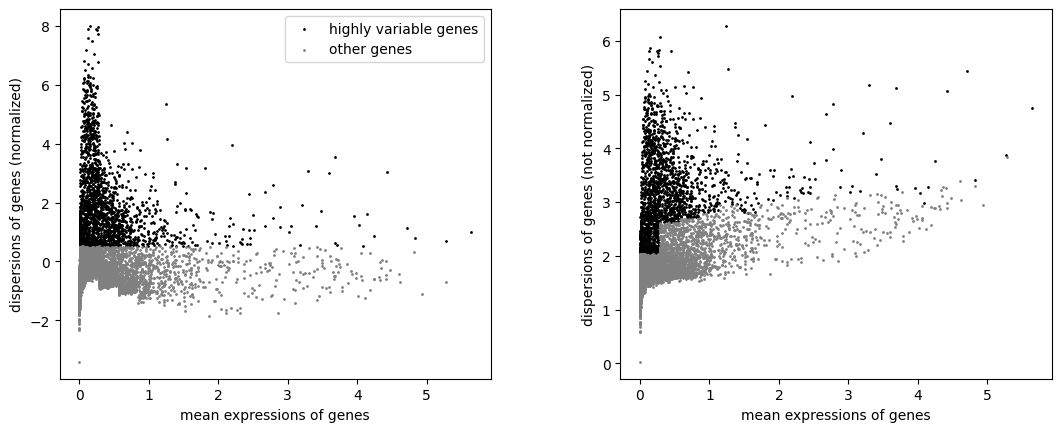

In [4]:
# Save raw counts, then normalize/log1p into .X (required by LLM-scCurator)
adata.layers["counts"] = adata.X.copy()

# Normalize + log1p (standard)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# HVG selection
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor="seurat",
    subset=False,
)
sc.pl.highly_variable_genes(adata)

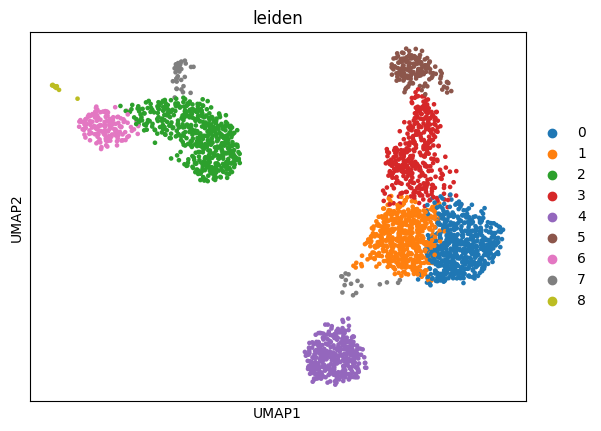

In [5]:
# PCA/Neighbors/UMAP/Leiden using HVGs
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=["leiden"])


##  Run LLM-scCurator, noise masking and Gini-informed distillation

In [6]:
ACCURACY_MODE = False  # set False for cheaper/faster

MODEL_NAME = "gpt-5.2" if ACCURACY_MODE else "gpt-4o"
print("Using model:", MODEL_NAME)

Using model: gpt-4o


In [7]:
# Recommended: store your key in Colab Secrets as "GEMINI_API_KEY"
from google.colab import userdata
OPENAI_API_KEY = userdata.get("OPENAI_API_KEY") or "YOUR_KEY_HERE"

In [8]:
# Curator Initialize
from llm_sc_curator.backends import OpenAIBackend

backend = OpenAIBackend(api_key=OPENAI_API_KEY, model_name=MODEL_NAME)
curator = LLMscCurator(backend=backend)
curator.set_global_context(adata)

In [9]:
# Choose a cluster (edit if you want a specific one)
cluster_name = sorted(adata.obs["leiden"].astype(str).unique())[0]
print(f"cluster_name = {cluster_name}")

cluster_name = 0


In [10]:
# --- Standard DE: Target vs Rest ---
N_GENES = 50
TMP = "__tmp_binary__"

# --- Standard: DE (Target vs Rest) ---
adata.obs[TMP] = "Rest"
adata.obs.loc[adata.obs["leiden"].astype(str) == str(cluster_name), TMP] = "Target"

sc.tl.rank_genes_groups(
    adata,
    groupby=TMP,
    groups=["Target"],
    reference="Rest",
    method="wilcoxon",
    use_raw=False,
)

df_std = sc.get.rank_genes_groups_df(adata, group="Target")
genes_std = df_std["names"].head(N_GENES).tolist()

adata.obs.drop(columns=[TMP], inplace=True, errors="ignore")

# --- Curated: LLM-scCurator ---
genes_cur = curator.curate_features(
    adata,
    group_col="leiden",
    target_group=str(cluster_name),
    n_top=N_GENES,
    use_statistics=True,
)

print("genes_std len =", len(genes_std))
print("genes_cur len =", len(genes_cur))


genes_std len = 50
genes_cur len = 50


In [11]:
# --- Readable output: lists + rescued/dropped + table ---
def _fmt_list(title, genes, n=10, bullet="•"):
    genes = [str(g) for g in (genes or [])]
    head = genes[:n]
    body = "\n".join([f"{bullet} {g}" for g in head]) if head else f"{bullet} (empty)"
    return f"{title} (top {len(genes)}, showing {min(n, len(genes))})\n{body}"

std = [str(g) for g in genes_std]
cur = [str(g) for g in genes_cur]

std_set = set(std)
cur_set = set(cur)

rescued = [g for g in cur if g not in std_set]
dropped = [g for g in std if g not in cur_set]
overlap = [g for g in cur if g in std_set]

print(f"\nGene list summary: std={len(std)} | curated={len(cur)} | shared={len(overlap)} | rescued={len(rescued)} | dropped={len(dropped)}\n")

print("🟦 " + _fmt_list("Standard genes", std, n=10))
print()
print("🟥 " + _fmt_list("Curated genes", cur, n=10))
print()
print("➕ " + _fmt_list("Rescued (curated-only)", rescued, n=10))
print()
print("➖ " + _fmt_list("Dropped (std-only)", dropped, n=10))

TOP = 15
def _pad(xs, n=TOP):
    xs = [str(x) for x in (xs or [])][:n]
    return xs + [""] * (n - len(xs))

df_view = pd.DataFrame({
    "🏆 rank ": list(range(1, TOP + 1)),
    "🟦 standard ": _pad(genes_std, TOP),
    "🟥 curated ":  _pad(genes_cur, TOP),
})

df_view.insert(0, "cluster", str(cluster_name))
df_view


Gene list summary: std=50 | curated=50 | shared=1 | rescued=49 | dropped=49

🟦 Standard genes (top 50, showing 10)
• RPS27
• RPL32
• RPS12
• RPS6
• RPS25
• RPS3A
• RPL31
• RPL9
• RPS15A
• RPS14

🟥 Curated genes (top 50, showing 10)
• CD3D
• CD3E
• LTB
• SELL
• SRSF5
• MAL
• GIMAP5
• HINT1
• TRAF3IP3
• CD3G

➕ Rescued (curated-only) (top 49, showing 10)
• CD3E
• LTB
• SELL
• SRSF5
• MAL
• GIMAP5
• HINT1
• TRAF3IP3
• CD3G
• LDLRAP1

➖ Dropped (std-only) (top 49, showing 10)
• RPS27
• RPL32
• RPS12
• RPS6
• RPS25
• RPS3A
• RPL31
• RPL9
• RPS15A
• RPS14


,cluster,🏆 rank,🟦 standard,🟥 curated
0,0,1,RPS27,CD3D
1,0,2,RPL32,CD3E
2,0,3,RPS12,LTB
3,0,4,RPS6,SELL
4,0,5,RPS25,SRSF5
5,0,6,RPS3A,MAL
6,0,7,RPL31,GIMAP5
7,0,8,RPL9,HINT1
8,0,9,RPS15A,TRAF3IP3
9,0,10,RPS14,CD3G


## (Optinal) Run LLM-scCurator hierarchical discovery (writes major_type / fine_type)

In [12]:
# ============================================================
# Optional: automatic hierarchical annotation (coarse-to-fine)
# ============================================================

# This will add columns like adata.obs["major_type"] and adata.obs["fine_type"].
%%time

# Curator Initialize
curator = LLMscCurator(backend=backend)

N_GENES = 50

import time
t0 = time.time()
adata_llm = curator.run_hierarchical_discovery(
    adata,
    n_top=N_GENES,
    batch_key=None, # set this if you want batch-aware behavior
)
t1 = time.time()

print(f"run_hierarchical_discovery() total: {t1 - t0:.1f} sec")
display(adata_llm.obs[["major_type","fine_type"]].head())


run_hierarchical_discovery() total: 70.3 sec


,major_type,fine_type
index,,
AAACATACAACCAC-1,CD8+ T cell,CD8+ effector T cell
AAACATTGAGCTAC-1,Naive B cell,Naive B cell
AAACATTGATCAGC-1,CD8+ T cell,CD4+ T cell
AAACCGTGCTTCCG-1,Monocyte,Classical Monocyte
AAACCGTGTATGCG-1,NK cell,Cytotoxic NK cell


CPU times: user 18.8 s, sys: 313 ms, total: 19.1 s
Wall time: 1min 10s


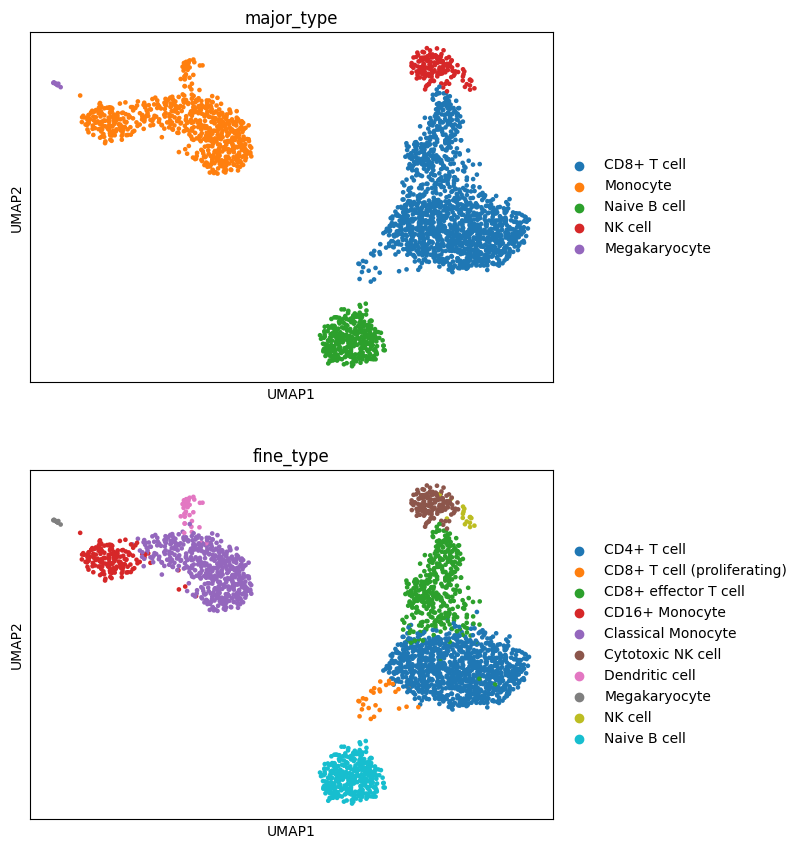

In [13]:
# Plot only if they exist
cols_to_plot = [c for c in ["major_type", "fine_type"] if c in adata.obs.columns]
if cols_to_plot and "X_umap" in adata.obsm:
    sc.pl.umap(adata, color=cols_to_plot, ncols=1)

## Quick marker dotplots for sanity-checking labels

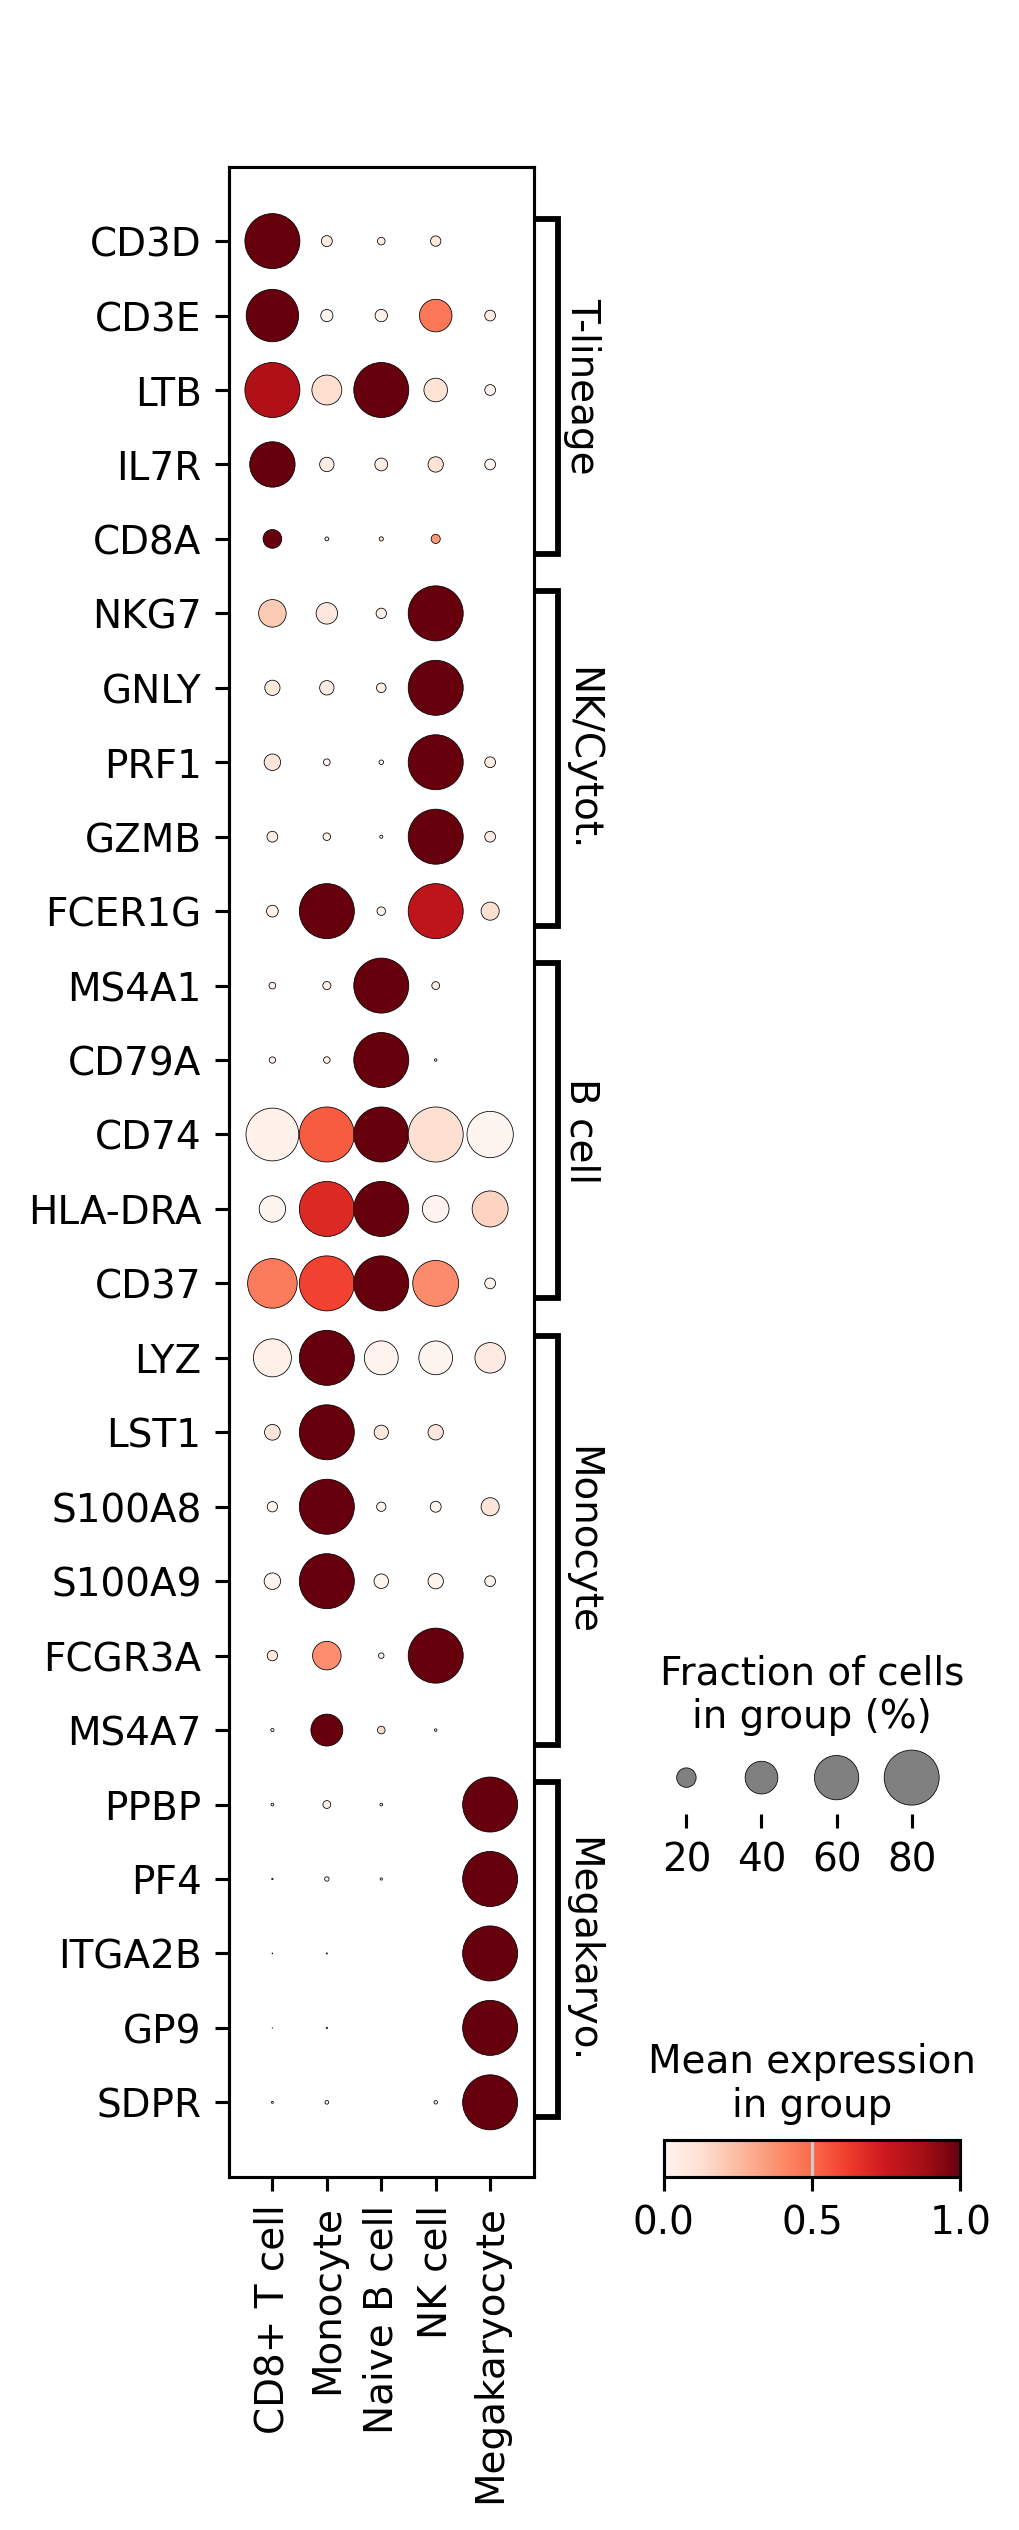

In [14]:
sc.set_figure_params(dpi=140, fontsize=12)

# ---------- marker panels (canonical) ----------
MARKERS_MAJOR = {
    "T-lineage":       ["CD3D", "CD3E", "LTB", "IL7R", "CD8A","TRAC"],
    "NK/Cytotoxic":    ["NKG7", "GNLY", "PRF1", "GZMB", "FCER1G"],
    "B cell":          ["MS4A1", "CD79A", "CD74", "HLA-DRA", "CD37"],
    "Monocyte":        ["LYZ", "LST1", "S100A8", "S100A9", "FCGR3A", "MS4A7"],
    "Megakaryocyte":   ["PPBP", "PF4", "ITGA2B", "GP9", "SDPR"],
}

# ---------- Utility: drop genes not present + dedupe across groups ----------
def filter_and_dedupe_markers(marker_dict, var_names):
    vset = set(map(str, var_names))
    used = set()
    out = {}
    for group, genes in marker_dict.items():
        cleaned = []
        for g in genes:
            g = str(g)
            if g not in vset:
                continue
            if g in used:
                continue
            cleaned.append(g)
            used.add(g)
        if cleaned:
            out[group] = cleaned
    return out

# Major type dotplot
markers = filter_and_dedupe_markers(MARKERS_MAJOR, adata.var_names)
sc.pl.dotplot(
    adata,
    markers,
    groupby="major_type",
    standard_scale="var",
    use_raw=False,
    swap_axes=True,
    dot_min=0.0,
    dot_max=0.8,
    show=True,
)





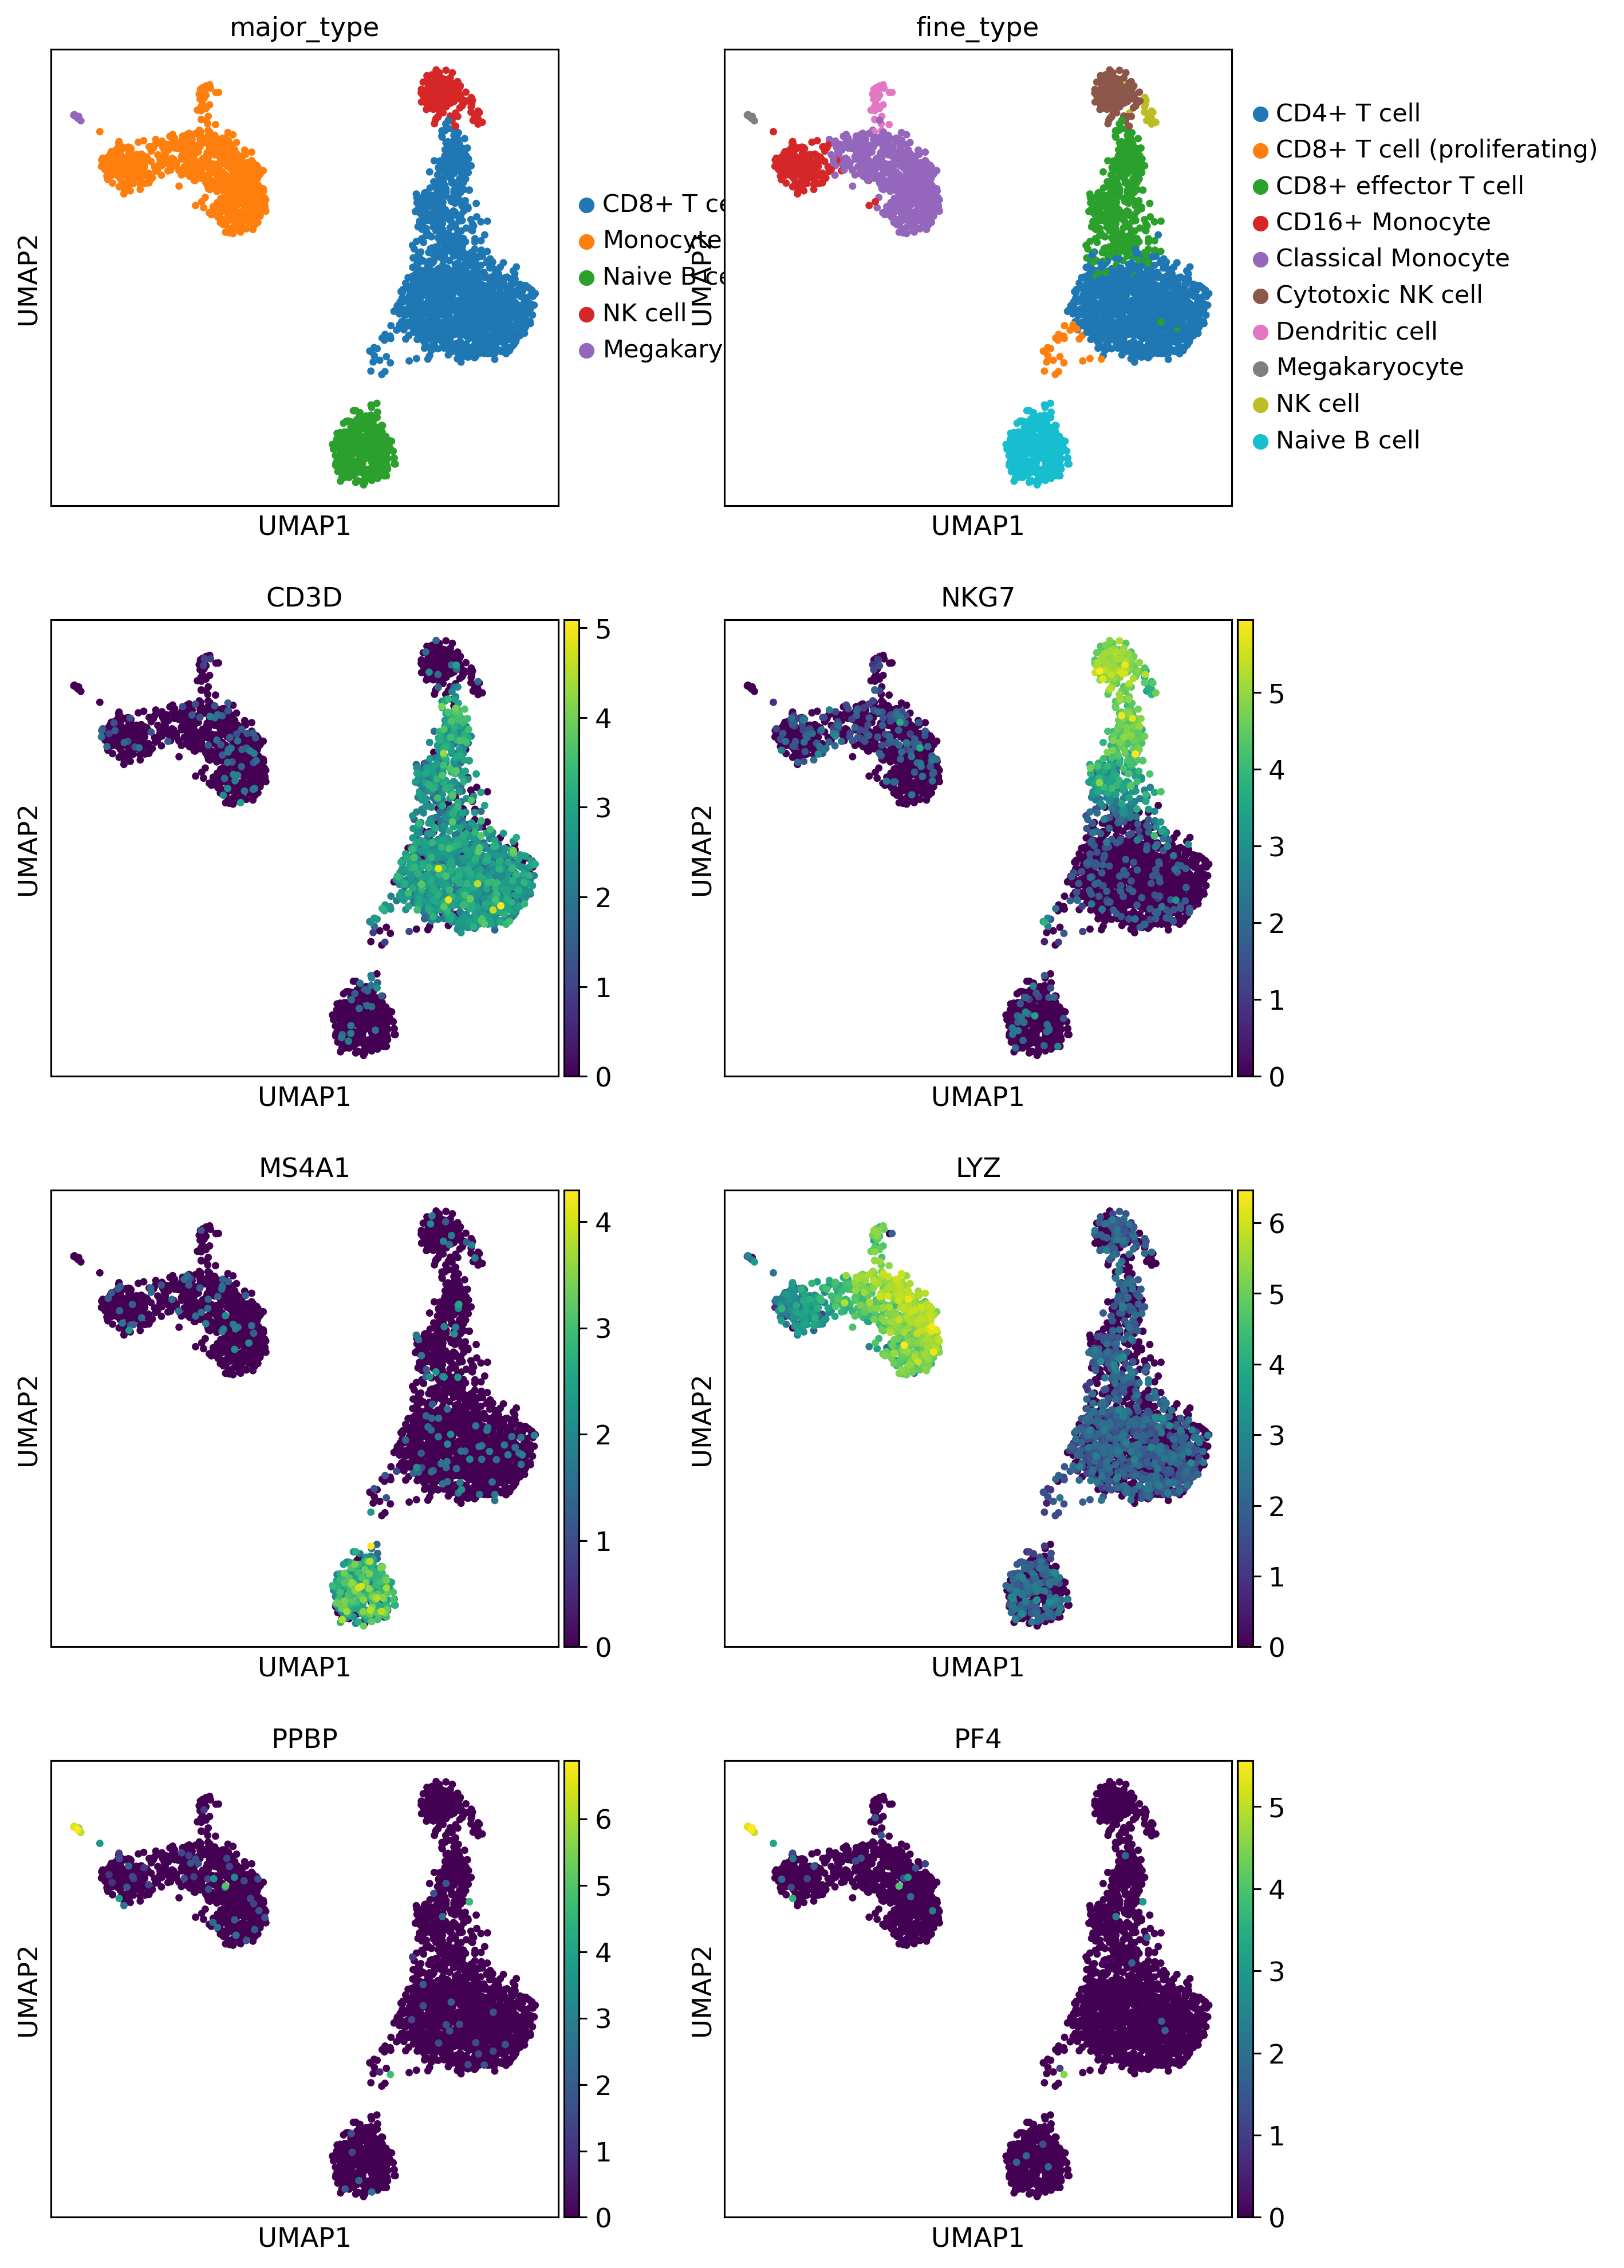

In [15]:
sc.pl.umap(adata_llm,
           color=["major_type",
                  "fine_type",
                  MARKERS_MAJOR["T-lineage"][0],
                  MARKERS_MAJOR["NK/Cytotoxic"][0],
                  MARKERS_MAJOR["B cell"][0],
                  MARKERS_MAJOR["Monocyte"][0],
                  ]+
                  MARKERS_MAJOR["Megakaryocyte"][:2],

           ncols=2,
           use_raw=False
           )


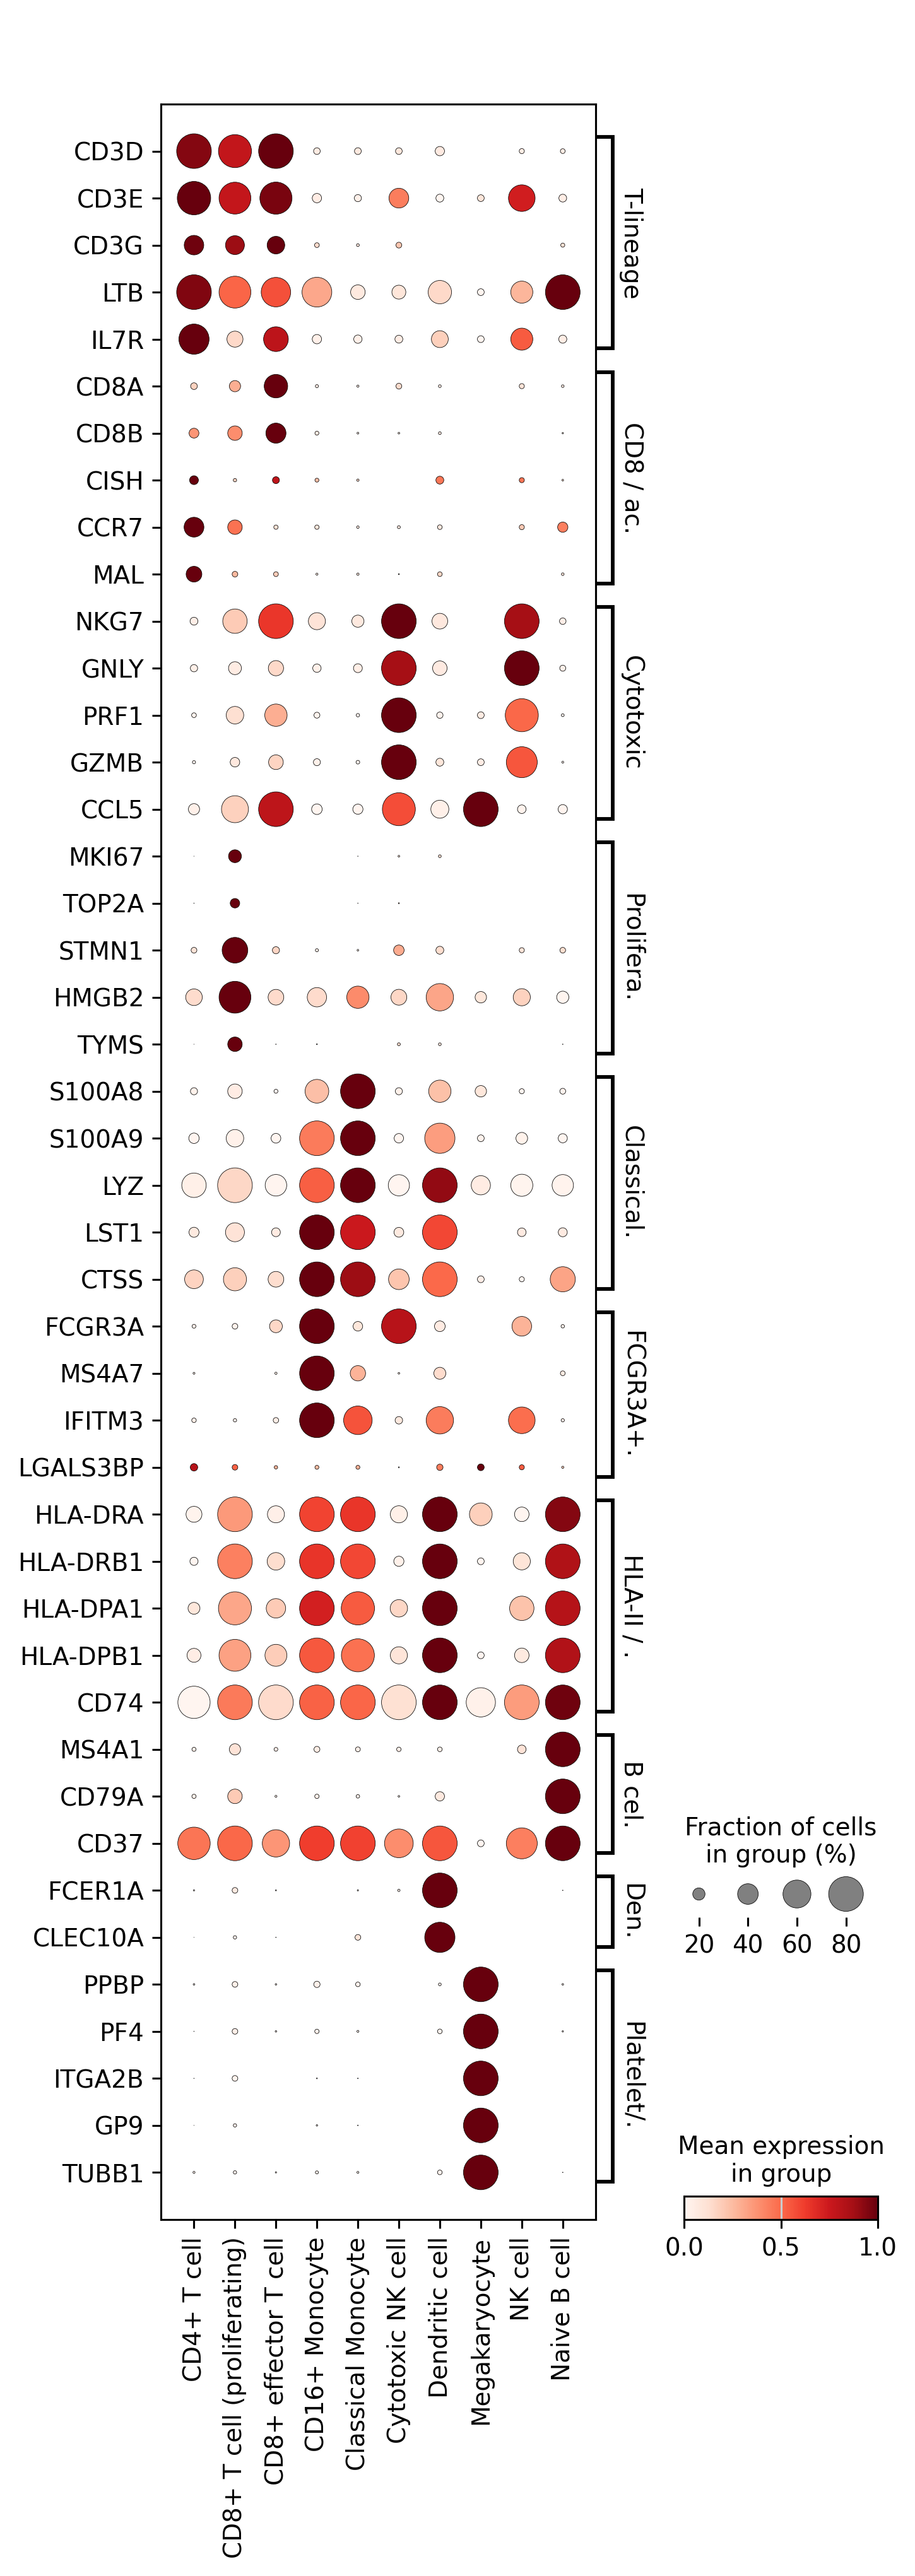

In [16]:
MARKERS_FINE = {
    "T-lineage":         ["TRAC", "CD3D", "CD3E", "CD3G", "LTB", "IL7R"],
    "CD8 / activation":  ["CD8A", "CD8B", "CISH", "CCR7", "MAL"],
    "Cytotoxic":         ["NKG7", "GNLY", "PRF1", "GZMB", "CCL5"],
    "Proliferation":     ["MKI67", "TOP2A", "STMN1", "HMGB2", "TYMS"],
    "Classical mono":    ["S100A8", "S100A9", "LYZ", "LST1", "CTSS"],
    "FCGR3A+ mono":      ["FCGR3A", "MS4A7", "IFITM3", "LGALS3BP"],
    "HLA-II / APC":      ["HLA-DRA", "HLA-DRB1", "HLA-DPA1", "HLA-DPB1", "CD74"],
    "B cell":            ["MS4A1", "CD79A", "CD74", "CD37"],
    "Dendritic (FCER1A+)": ["FCER1A", "CLEC10A"],
    "Platelet/Megakaryocyte": ["PPBP", "PF4", "ITGA2B", "GP9", "TUBB1"],
}



# ---------- Plot settings ----------
markers = filter_and_dedupe_markers(MARKERS_FINE, adata.var_names)
sc.pl.dotplot(
    adata,
    markers,
    groupby="fine_type",
    standard_scale="var",
    use_raw=False,
    swap_axes=True,
    dot_min=0.0,
    dot_max=0.8,
    show=True,
)
